In [9]:
from __future__ import print_function
import time
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

In [12]:
class CVAE(nn.Module):
    def __init__(self, input_size, latent_size, class_size):
        super(CVAE, self).__init__()
        self.input_size = input_size
        self.class_size = class_size
        self.latent_size = latent_size
        self.units = 400

        ######################################################
        ###              START OF YOUR CODE                ###
        ######################################################
        ### Define a three layer neural network architecture #
        ### for the recognition_model                        #
        ######################################################
        self.relu = nn.ReLU()
        
        self.sigmoid = nn.Sigmoid()
        self.affine_1 = nn.Linear(input_size + class_size, self.units)
        self.affine_2 = nn.Linear(self.units, self.units)
        
        self.mu = nn.Linear(self.units, latent_size)
        self.logvar = nn.Linear(self.units, latent_size)

        ######################################################
        ###               END OF YOUR CODE                 ###
        ######################################################

        ######################################################
        ###              START OF YOUR CODE                ###
        ######################################################
        ### Define a three layer neural network architecture #
        ### for the generation_model                         #
        ######################################################
        self.affine_3 = nn.Linear(latent_size + class_size, self.units)
        self.affine_4 = nn.Linear(self.units, self.units)
        
        self.output = nn.Linear(self.units, input_size)

        ######################################################
        ###               END OF YOUR CODE                 ###
        ######################################################



    def recognition_model(self, x, c):
        """
        Computes the parameters of the posterior distribution q(z | x, c) using the
        recognition network defined in the constructor
    
        Inputs:
        - x: PyTorch Variable of shape (batch_size, input_size) for the input data
        - c: PyTorch Variable of shape (batch_size, num_classes) for the input data class
        
        Returns:
        - mu: PyTorch Variable of shape (batch_size, latent_size) for the posterior mu
        - logvar PyTorch Variable of shape (batch_size, latent_size) for the posterior
          variance in log space
        """
        ###########################
        ######### TO DO ###########
        ###########################
        mu = None
        logvar = None
        
        inputs = torch.cat([x,c], 1)
        h_1 = self.relu(self.affine_1(inputs))
        h_2 = self.relu(self.affine_2(h_1))
        
        mu = self.mu(h_2)
        logvar = self.logvar(h_2)
        
        return mu, logvar


    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = Variable(std.data.new(std.size()).normal_())
        return eps.mul(std) + mu

    def generation_model(self, z, c): # P(x|z, c)
        """
        Computes the generation output from the generative distribution p(x | z, c)
        using the generation network defined in the constructor
    
        Inputs:
        - z: PyTorch Variable of shape (batch_size, latent_size) for the latent vector
        - c: PyTorch Variable of shape (batch_size, num_classes) for the input data class
        
        Returns:
        - x_hat: PyTorch Variable of shape (batch_size, input_size) for the generated data
        """
        ###########################
        ######### TO DO ###########
        ###########################
        x_hat = None
        
        inputs = torch.cat([z,c], 1)
        h_3 = self.relu(self.affine_3(inputs))
        h_4 = self.relu(self.affine_4(h_3))
        
        x_hat = self.sigmoid(self.output(h_4))
        
        return x_hat

    def forward(self, x, c):
        """
        Performs the inference and generation steps of the CVAE model using
        the recognition_model, reparametrization trick, and generation_model
    
        Inputs:
        - x: PyTorch Variable of shape (batch_size, input_size) for the input data
        - c: PyTorch Variable of shape (batch_size, num_classes) for the input data class
        
        Returns:
        - x_hat: PyTorch Variable of shape (batch_size, input_size) for the generated data
        - mu: PyTorch Variable of shape (batch_size, latent_size) for the posterior mu
        - logvar: PyTorch Variable of shape (batch_size, latent_size)
                  for the posterior logvar
        """
        ###########################
        ######### TO DO ###########
        ###########################
        x_hat = None
        mu = None
        logvar = None
        
        mu, logvar = self.recognition_model(x, c)
        p = self.reparametrize(mu, logvar)
        x_hat = self.generation_model(p, c)
        
        return x_hat, mu, logvar


def to_var(x, use_cuda):
    x = Variable(x)
    if use_cuda:
        x = x.cuda()
    return x


def one_hot(labels, class_size, use_cuda):
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return to_var(targets, use_cuda)


def train(epoch, model, train_loader, optimizer, num_classes, use_cuda):
    model.train()
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = to_var(data, use_cuda).view(data.shape[0], -1)
        labels = one_hot(labels, num_classes, use_cuda)
        recon_batch, mu, logvar = model(data, labels)
        optimizer.zero_grad()
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.data
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data / len(data)))


def loss_function(x_hat, x, mu, logvar):
    """
    Computes the negative variational lowerbound for conditional vae
    Note: We compute -lowerbound because we optimize the network by minimizing a loss

    Inputs:
    - x_hat: PyTorch Variable of shape (batch_size, input_size) for the generated data
    - x: PyTorch Variable of shape (batch_size, input_size) for the real data
    - mu: PyTorch Variable of shape (batch_size, latent_size) for the posterior mu
    - logvar: PyTorch Variable of shape (batch_size, latent_size) for the posterior logvar
    
    Returns:
    - loss: PyTorch Variable containing the (scalar) loss for the negative lowerbound.
    """
    ###########################
    ######### TO DO ###########
    ###########################
    loss = None    
    batch_size, input_size = x.shape
    loss1 = F.binary_cross_entropy(x_hat, x.view(-1, input_size), size_average = False)
    loss2 = 0.5 * torch.sum(torch.exp(logvar) + mu**2 - 1 - logvar)
    loss = loss1 + loss2
    
    return loss

In [13]:
# Load MNIST dataset
use_cuda = False
input_size = 28 * 28
units = 400
batch_size = 32
latent_size = 20 # z dim
num_classes = 10
num_epochs = 10

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
dataset = datasets.MNIST(
    './data',  train=True, download=True,
    transform=transforms.ToTensor())
train_dataset = torch.utils.data.Subset(dataset, indices=range(10000))
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=True, **kwargs)

model = CVAE(input_size, latent_size, num_classes)

if use_cuda:
    model.cuda()

# Note: You will get an ValueError here if you haven't implemented anything
optimizer = optim.Adam(model.parameters(), lr=1e-3)
start = time.time()
for epoch in range(1, num_epochs+1):
    train(epoch, model, train_loader, optimizer, num_classes, use_cuda)
print('training time = %f'%(time.time() - start)) # should take less than 5 minutes

Train Epoch: 1 [0/10000 (0%)]	Loss: 543.240723
Train Epoch: 1 [3200/10000 (32%)]	Loss: 201.134949
Train Epoch: 1 [6400/10000 (64%)]	Loss: 177.762085
Train Epoch: 1 [9600/10000 (96%)]	Loss: 151.249939
Train Epoch: 2 [0/10000 (0%)]	Loss: 160.465515
Train Epoch: 2 [3200/10000 (32%)]	Loss: 152.169418
Train Epoch: 2 [6400/10000 (64%)]	Loss: 139.108032
Train Epoch: 2 [9600/10000 (96%)]	Loss: 133.159058
Train Epoch: 3 [0/10000 (0%)]	Loss: 130.044952
Train Epoch: 3 [3200/10000 (32%)]	Loss: 133.692581
Train Epoch: 3 [6400/10000 (64%)]	Loss: 137.082275
Train Epoch: 3 [9600/10000 (96%)]	Loss: 131.122971
Train Epoch: 4 [0/10000 (0%)]	Loss: 123.993256
Train Epoch: 4 [3200/10000 (32%)]	Loss: 122.653526
Train Epoch: 4 [6400/10000 (64%)]	Loss: 120.095825
Train Epoch: 4 [9600/10000 (96%)]	Loss: 124.420311
Train Epoch: 5 [0/10000 (0%)]	Loss: 118.155006
Train Epoch: 5 [3200/10000 (32%)]	Loss: 105.047661
Train Epoch: 5 [6400/10000 (64%)]	Loss: 120.164001
Train Epoch: 5 [9600/10000 (96%)]	Loss: 119.830498


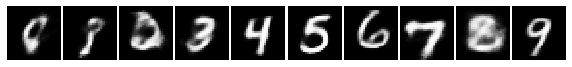

In [16]:
# Generate images with condition labels
c = torch.eye(num_classes, num_classes) # [one hot labels for 0-9]
c = to_var(c, use_cuda)
z = to_var(torch.randn(num_classes, latent_size), use_cuda)
samples = model.generation_model(z, c).data.cpu().numpy()

fig = plt.figure(figsize=(10, 1))
gs = gridspec.GridSpec(1, 10)
gs.update(wspace=0.05, hspace=0.05)
for i, sample in enumerate(samples):
    ax = plt.subplot(gs[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

plt.show()